In [1]:
import sys
sys.path.append("../..")

import kmapper as km
import matplotlib.pyplot as plt
import numpy as np
import evaluate

import sklearn
import networkx as nx

# Users need to access https://people.csail.mit.edu/sumner/research/deftransfer/data.html to download Cat poses dataset and we use cat-reference.obj here.

def load_obj(obj_path):
    points = []
    i=0 
    with open(obj_path) as file:
        while 1:
            line = file.readline()

            if not line:
                break
            strs = line.split(" ")
            if strs[0] == "v":
                temp = []
                for j in range(1,len(strs)):                
                    if strs[j] != "":
                        temp.append(float(strs[j]))

                points.append(np.array(temp) )
        points = np.array(points)
        return points

cat_data = load_obj("cat-reference.obj")

def rotation_matrix_x(angle):
    angle = np.radians(angle)
    return np.array([
        [1, 0, 0],
        [0, np.cos(angle), -np.sin(angle)],
        [0, np.sin(angle), np.cos(angle)]
    ])

def rotation_matrix_y(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle), 0, np.sin(angle)],
        [0, 1, 0],
        [-np.sin(angle), 0, np.cos(angle)]
    ])

def rotation_matrix_z(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]])



D_Mapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (7207, 3)

..Projecting data using: sum

..Scaling with: MinMaxScaler()

Mapping on data shaped (7207, 3) using lens shaped (7207, 1)



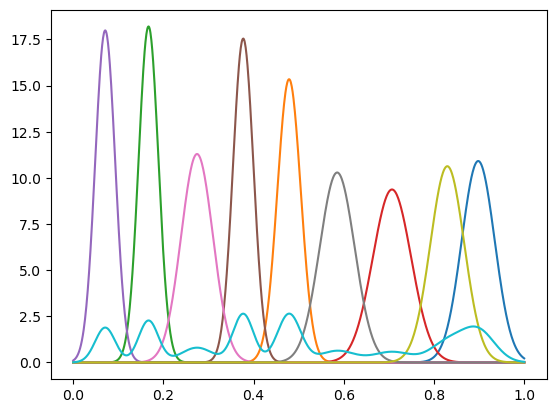

 - Cover - centers: [0.06396283506917626, 0.16686688946993963, 0.2744918470139124, 0.3769374711355464, 0.4786168666591337, 0.5852872804292476, 0.7068626672147353, 0.8295281057499228, 0.9019549430219653]
inner_range: [0.88888889]
radius: [0.06396283506917626, 0.05644287325910699, 0.09098253191968447, 0.05855496220482398, 0.06695859823052472, 0.09983892165412245, 0.10962603963372836, 0.09664639898567995, 0.09804505697803473]
bic:-2800.930524260596
alpha_max:0.02
Minimal points in hypercube before clustering: 5
Creating 9 hypercubes.
   > Found 2 clusters in hypercube 0.
   > Found 2 clusters in hypercube 1.
   > Found 2 clusters in hypercube 2.
   > Found 2 clusters in hypercube 3.
   > Found 1 clusters in hypercube 4.
   > Found 1 clusters in hypercube 5.
   > Found 1 clusters in hypercube 6.
   > Found 1 clusters in hypercube 7.
   > Found 1 clusters in hypercube 8.

Created 13 edges and 13 nodes in 0:00:01.239899.


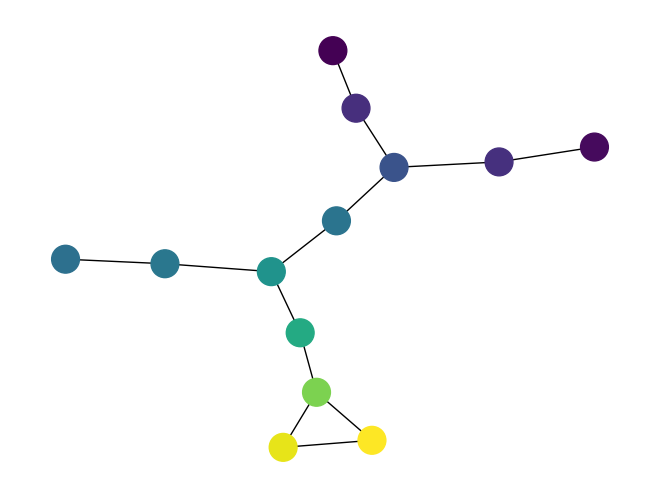

100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


SC:0.0222257993507
SC_norm:0.51111289967535
TSR:1.0
SC_adj:0.755556449837675


In [2]:
np.random.seed(4)
mapper = km.D_Mapper(verbose=2)
data = cat_data

projected_data = mapper.fit_transform(data)
n = 9
a = 0.01

cover = km.D_Cover(n_cubes = n, alpha = a,max_iter=100000,n_init=10,verbose=1)
graphD = mapper.map(
    projected_data,
    data,
    clusterer = sklearn.cluster.DBSCAN(eps=0.1, min_samples=5),
    cover= cover
)
interval_table_1 = cover.interval_table

color_list1 = []
for i in range(len(graphD['nodes'])):
    index_list = [l for l in graphD['nodes'].values()][i]
    color = np.mean(projected_data[index_list])
    color_list1.append(color)
G1 = km.adapter.to_networkx(graphD)
nx.draw(G1, pos=nx.kamada_kawai_layout(G1), node_color=color_list1, node_size =400)
plt.savefig('catg.png', bbox_inches='tight')
plt.show()

SC_adj = evaluate.compute_SC_adj(data, projected_data, graphD, km.D_Cover(n_cubes = n, alpha = a,max_iter=100000,n_init=10,verbose=0), type = 'd'
                                 , cluster = sklearn.cluster.DBSCAN(eps=0.1, min_samples=5))

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (7207, 3)

..Projecting data using: sum

..Scaling with: MinMaxScaler()

Mapping on data shaped (7207, 3) using lens shaped (7207, 1)

Creating 9 hypercubes.

Created 10 edges and 11 nodes in 0:00:00.139772.


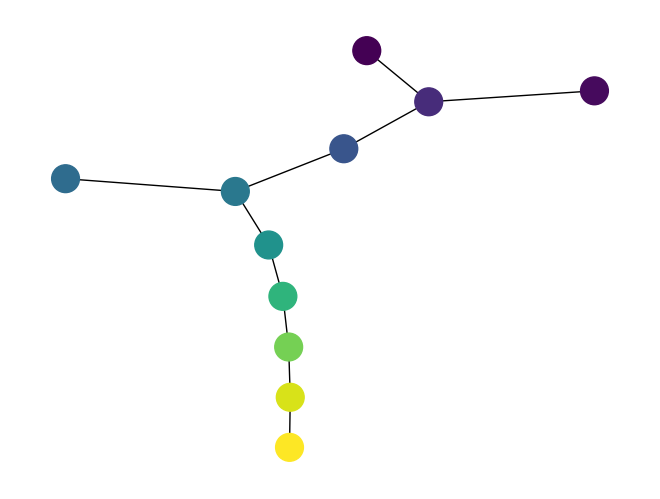

100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


SC:-0.03832295563
SC_norm:0.480838522185
TSR:1.0
SC_adj:0.7404192610925


In [3]:
n = 9
a = 0.32
data = cat_data
mapper = km.KeplerMapper(verbose=1)
projected_data = mapper.fit_transform(data)
cover = km.Cover(n_cubes=n,perc_overlap=a)
graph = mapper.map(projected_data, data, clusterer=sklearn.cluster.DBSCAN(eps=0.1, min_samples=5),cover=cover)

interval_table_2 = np.zeros((2,n))  
s = cover.bounds_[0]
L = cover.bounds_[1] - cover.bounds_[0]
x = L/(n-(n-1)*a)
for i in range(n):
    interval_table_2[0,i] = s
    interval_table_2[1,i] = s + x
    s = s + (1 - a )*x
    
color_list2 = []
for i in range(len(graph['nodes'])):
    index_list = [l for l in graph['nodes'].values()][i]
    color = np.mean(projected_data[index_list])
    color_list2.append(color)
G2 = km.adapter.to_networkx(graph)
nx.draw(G2, pos=nx.kamada_kawai_layout(G2), node_color=color_list2, node_size =400)
plt.savefig('cat.png')
plt.show()

SC_adj = evaluate.compute_SC_adj(data, projected_data, graph, cover, type = 'k', cluster = sklearn.cluster.DBSCAN(eps=0.1, min_samples=5) )

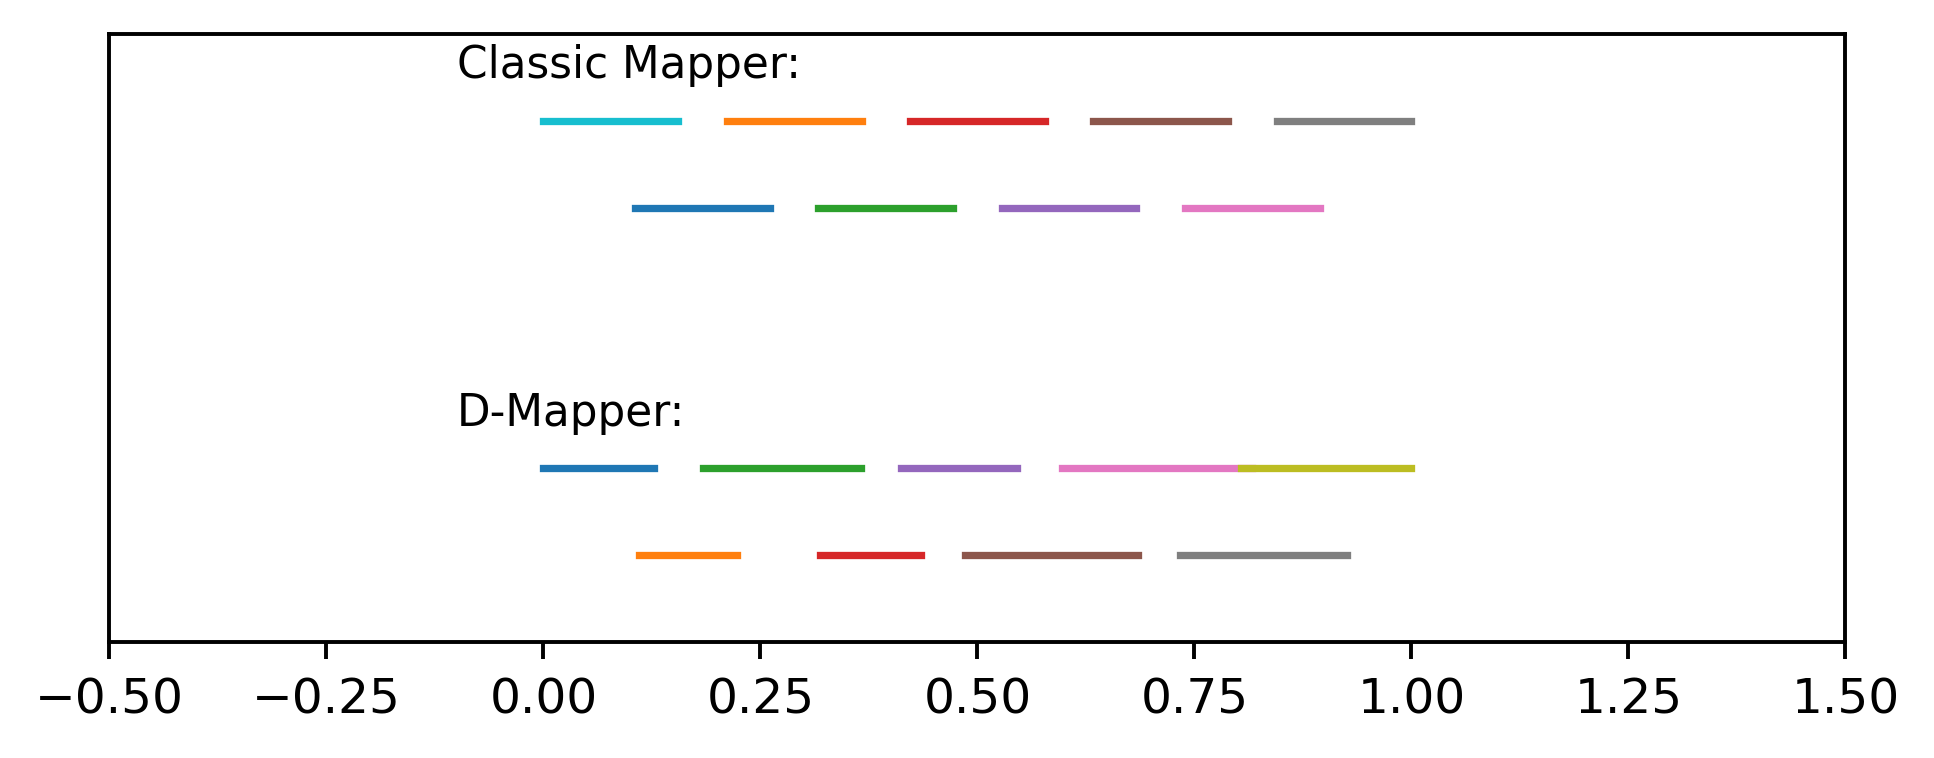

In [4]:
plt.figure(dpi=350)
#G_mapper interval
for i in range(1,interval_table_1.shape[1]+1):
    plt.plot([interval_table_1[0,i-1],interval_table_1[1,i-1]],[0.1*(i % 2)-2,0.1*(i%2)-2])

#mapper interval
for i in range(1,interval_table_2.shape[1]+1):
    plt.plot([interval_table_2[0,i-1],interval_table_2[1,i-1]],[0.1*(i % 2)-1.6,0.1*(i%2)-1.6])

plt.text(-0.1, -1.85, 'D-Mapper:', fontsize=9) 
plt.text(-0.1, -1.45, 'Classic Mapper:', fontsize=9) 

ax = plt.gca()
ax.set_aspect(1)
plt.xlim((-0.5, 1.5))
plt.ylim((-2.1, -1.4))
plt.yticks([])
#plt.savefig("interval_fig3.jpg",dpi=350, bbox_inches='tight')
plt.savefig("interval_fig3.eps", bbox_inches='tight')
plt.show()


In [5]:


layout1 = {'cube0_cluster0': np.array([ 1.        , -0.63766999]), 'cube0_cluster1': np.array([0.99910118, 0.20774561]), 'cube1_cluster0': 
           np.array([ 0.79142246, -0.45319388]), 'cube1_cluster1': np.array([0.79917658, 0.01707329]), 'cube2_cluster0': np.array([ 0.54719729, -0.20946011]), 'cube2_cluster1': np.array([-0.6992888 , -0.60180606]), 
           'cube3_cluster0': np.array([ 0.13097613, -0.17164073]), 'cube3_cluster1': np.array([-0.51612196, -0.38429184]), 'cube4_cluster0': np.array([-0.28782409, -0.11066612]), 'cube5_cluster0': np.array([-0.50223623,  0.22476229]), 
           'cube6_cluster0': np.array([-0.68015752,  0.55628415]), 'cube7_cluster0': np.array([-0.71257601,  0.81841221]), 'cube8_cluster0': np.array([-0.86966904,  0.74445119])}

layout2 = {'cube0_cluster0': np.array([ 0.98334788, -0.11826101]), 'cube0_cluster1': np.array([ 1.        , -0.43778835]), 'cube1_cluster0': np.array([ 0.7738755 , -0.28899141]), 'cube2_cluster0': np.array([ 0.42052668, -0.31562293]), 
           'cube2_cluster1': np.array([-0.0331435 , -0.56904368]), 'cube3_cluster0': np.array([ 0.04880723, -0.31385205]), 'cube4_cluster0': np.array([-0.25598137, -0.10616791]), 'cube5_cluster0': np.array([-0.51211954,  0.13652964]),
            'cube6_cluster0': np.array([-0.70969508,  0.40558351]), 'cube7_cluster0': np.array([-0.83656155,  0.68018964]), 'cube8_cluster0': np.array([-0.87905625,  0.92742454])}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


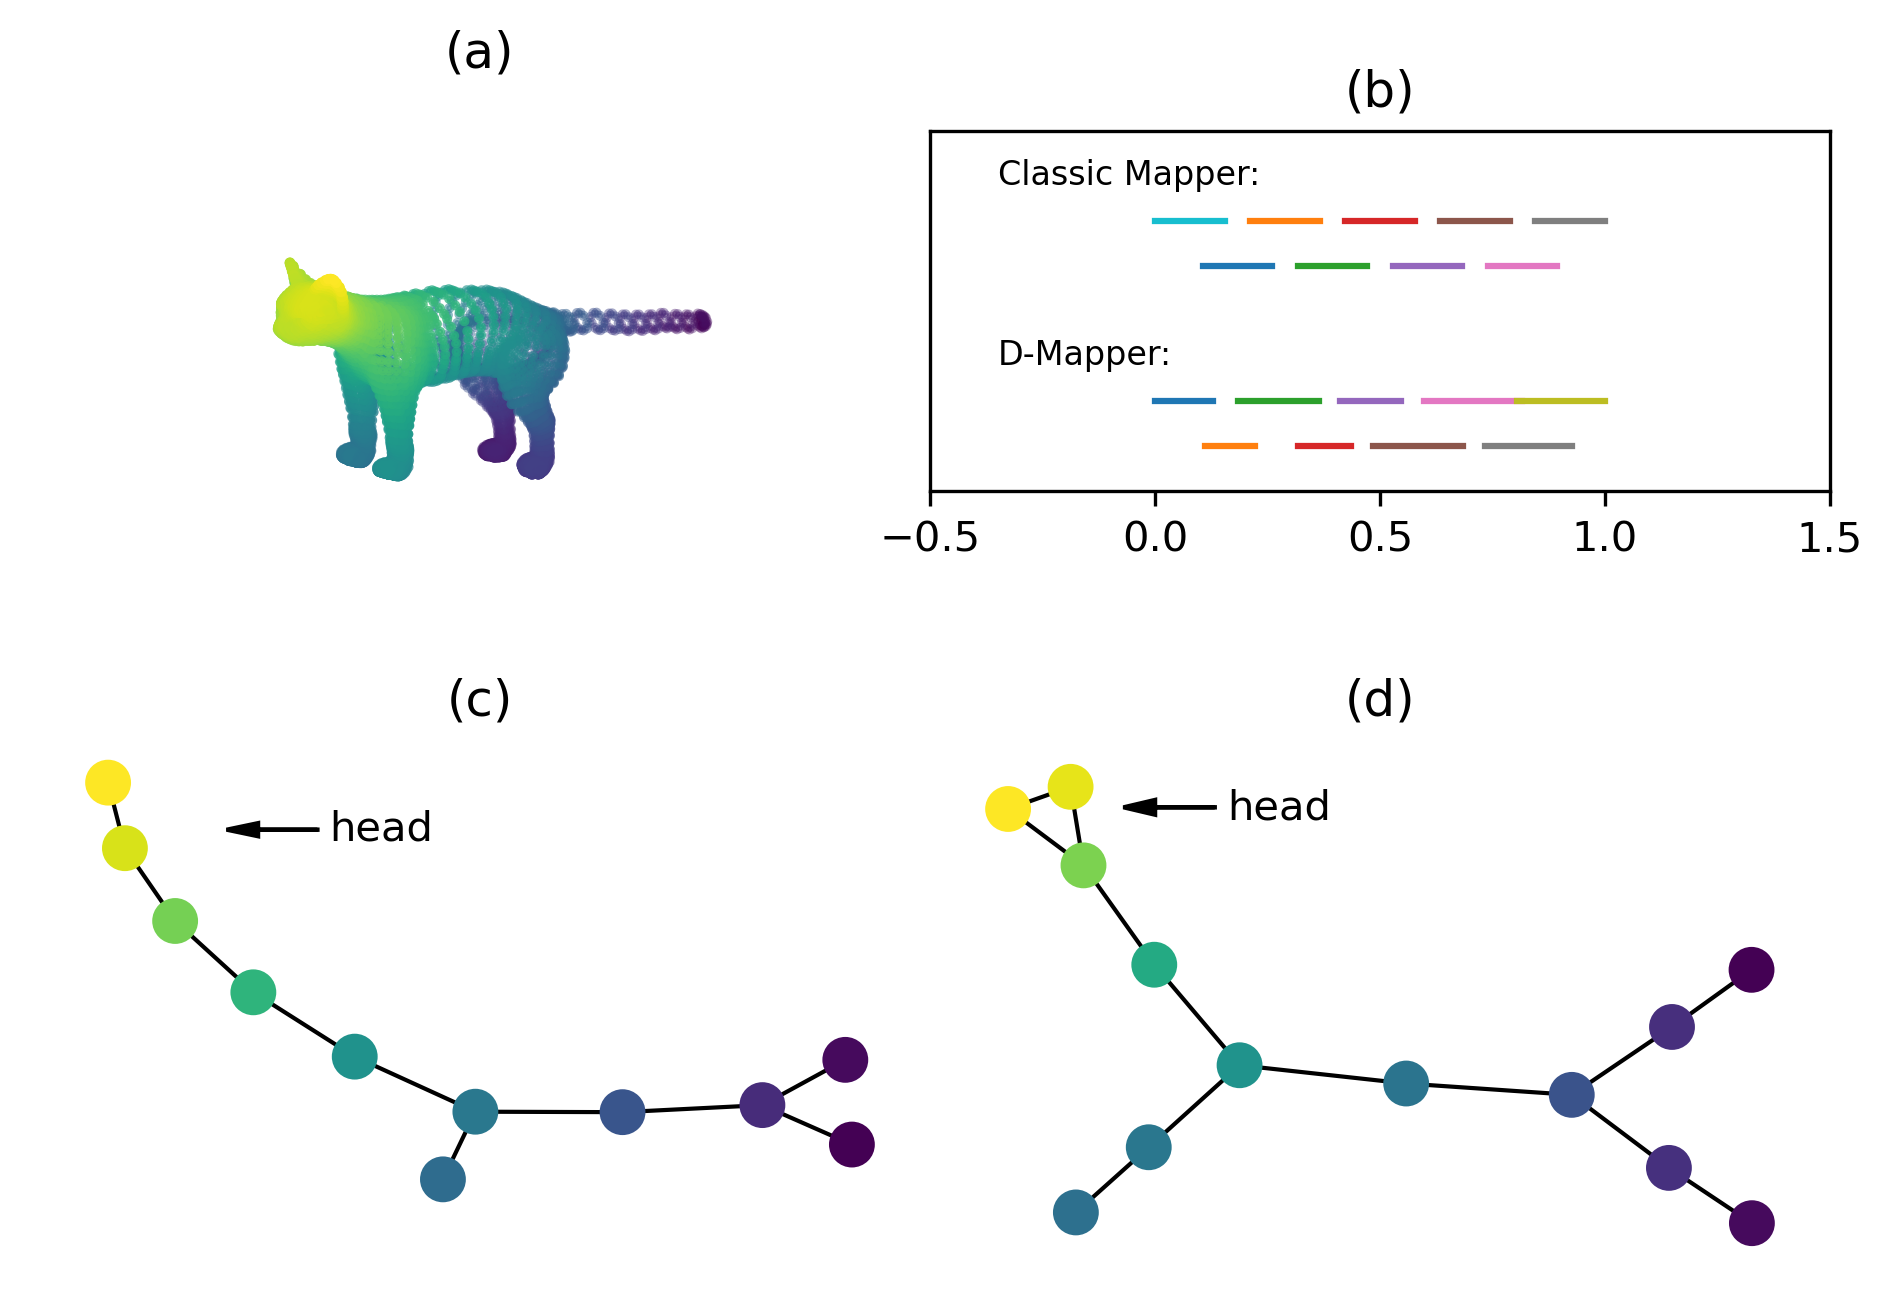

In [6]:

fig = plt.figure(figsize=(6, 8),dpi=300)
s=1

# add subfig
cat_data = load_obj("cat-reference.obj")

'''cat_data = np.dot(cat_data,rotation_matrix_x(-85) )
cat_data = np.dot(cat_data,rotation_matrix_y(5))
cat_data = np.dot(cat_data,rotation_matrix_z(5))'''



cat_data = np.dot(cat_data,rotation_matrix_x(-82) )
cat_data = np.dot(cat_data,rotation_matrix_y(12))
cat_data = np.dot(cat_data,rotation_matrix_z(30) )

xd = cat_data[:,0]
yd = cat_data[:,1]
zd = cat_data[:,2]

ax = fig.add_axes([0, 0.75,0.5,0.22],projection='3d', proj_type='ortho')
ax.scatter3D(s*xd,s*yd,s*zd, c = projected_data,s=2)
ax.grid(None)
ax.axis('off')
ax.set_title("(a)")
axis = plt.gca()
axis.margins(-0.499999)

ax1 = fig.add_axes([0.5, 0.769,0.5,0.22])
ax1.set_title("(b)")
for i in range(1,interval_table_1.shape[1]+1):
    plt.plot([interval_table_1[0,i-1],interval_table_1[1,i-1]],[0.1*(i % 2)-2,0.1*(i%2)-2])

#mapper interval
for i in range(1,interval_table_2.shape[1]+1):
    plt.plot([interval_table_2[0,i-1],interval_table_2[1,i-1]],[0.1*(i % 2)-1.6,0.1*(i%2)-1.6])
ax = plt.gca()
ax.set_aspect(1)
plt.xlim((-0.5, 1.5))
plt.ylim((-2.1, -1.3))
plt.yticks([])
plt.text(-0.35, -1.82, 'D-Mapper:', fontsize=8) 
plt.text(-0.35, -1.42, 'Classic Mapper:', fontsize=8) 



ax2 = fig.add_axes([0, 0.5, 0.5,0.2])
ax2.set_title("(c)")
nx.draw(G2, pos=layout2, node_color=color_list2, node_size =100, ax=ax2)
plt.arrow(-0.35, 0.75,-0.15,0,head_width=0.05,head_length=0.08,fc='black')
plt.text(-0.32, 0.71, 'head', fontsize=10)

ax3 = fig.add_axes([0.5, 0.48, 0.5 ,0.22])
ax3.set_title("(d)")
nx.draw(G1, pos=layout1, node_color=color_list1, node_size =100, ax=ax3)
plt.arrow(-0.35, 0.75,-0.15,0,head_width=0.05,head_length=0.08,fc='black')
plt.text(-0.32, 0.71, 'head', fontsize=10)   


# save and show
#plt.savefig("cat.jpg",dpi=350, bbox_inches='tight')
plt.savefig("cat.eps", bbox_inches='tight')
plt.show()